In [31]:
import numpy as np
import pandas as pd
import sys
from sklearn import preprocessing
from sklearn.pipeline import FeatureUnion, Pipeline, make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn import tree
import sklearn.model_selection as model_selection

In [32]:
class SentenceEmbeddingTransform():
    def __init__(self, wordList, vocab, W_norm):
        print()
        self.wordList = wordList
        self.W_norm = W_norm
        self.vocab = vocab
    
    def fit(self, X, y = None):
        return self
    
    def mean_of_word_embedding(self, input_term):
        words_inDict = np.empty([0])
        
        for idx, term in enumerate(input_term.split(' ')):
            if term in self.vocab:
                words_inDict = np.append(words_inDict, term)
                
        vec_sentence_embed = [self.W_norm[self.vocab[y], :] for y in words_inDict]
        vec_sentence_embed_stack = np.vstack(vec_sentence_embed)
        vec_sentence_embed_stack_mean = np.mean(vec_sentence_embed_stack, axis=0)
        
        return vec_sentence_embed_stack_mean
    
    def transform(self, X, y = None):
        X_ = X.copy()
        
        ret_array = []
        
        for sentence in X_:
            arr_result = self.mean_of_word_embedding(sentence.lower())
            ret_array.append(arr_result)

        return np.array(ret_array)
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [33]:
class MyLabelEncoder():

    def transform(self, X, y=None, **fit_params):
        enc = preprocessing.LabelEncoder()
        encc = enc.fit(X)
        enc_data = enc.transform(X).reshape(-1, 1)

        return enc_data

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X).reshape(-1, 1)

    def fit(self, X, y=None, **fit_params):
        return self

In [34]:
vector_file = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\Word2Vec\\CBOW\\TXT\\corpus-plus-simral-40-1-vector.txt"
vocab_file = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\Word2Vec\\CBOW\\TXT\\corpus-plus-simral-40-1-vocab.txt"

with open(vocab_file, 'r', encoding='utf-8') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
    
with open(vector_file, 'r', encoding='utf-8') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_size = len(words)
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v
    
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))

W_norm = (W.T / d).T

lst_keys = [y for y in vocab.keys()]

In [35]:
csvPath = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\KLASIFIKASI\\labeled_2019_merged_edited.csv"

data = pd.read_csv(csvPath)

data['label'] = data['label'].fillna(value=0.0)
data.shape

data = data.dropna(axis=0, subset=['namaprogram', 'namaoutput', 'namaoutcome', 'namakegiatan', 'satuanoutput', 'satuanoutcome'])

In [70]:
def get_text_satuan_outcome(df):
    return df['satuanoutcome']

def get_text_satuan_output(df):
    return df['satuanoutput']

def get_text_nama_program(df):
    return df['namaprogram']

def get_text_nama_kegiatan(df):
    return df['namakegiatan']

def get_text_nama_output(df):
    return df['namaoutput']

def get_text_nama_outcome(df):
    return df['namaoutcome']

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_text_satuan_outcome, validate=False), MyLabelEncoder()),
    make_pipeline(FunctionTransformer(get_text_satuan_output, validate=False), MyLabelEncoder()),
    make_pipeline(FunctionTransformer(get_text_nama_program, validate=False), SentenceEmbeddingTransform(lst_keys, vocab, W_norm)),
    make_pipeline(FunctionTransformer(get_text_nama_kegiatan, validate=False), SentenceEmbeddingTransform(lst_keys, vocab, W_norm)),
    make_pipeline(FunctionTransformer(get_text_nama_output, validate=False), SentenceEmbeddingTransform(lst_keys, vocab, W_norm)),
    make_pipeline(FunctionTransformer(get_text_nama_outcome, validate=False), SentenceEmbeddingTransform(lst_keys, vocab, W_norm))
])

In [37]:
neo_pipeline = Pipeline([
    ('thevec', vec),
    ('dectree', tree.DecisionTreeClassifier())  # classifier
])

data_column_used = data[['namaprogram', 'satuanoutcome', 'satuanoutput', 'namakegiatan', 'namaoutput', 'namaoutcome']]
data_target = data['label'].astype(int)

In [65]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_column_used, data_target, train_size=0.9,test_size=0.1,random_state=42)

neo_pipeline.fit(X_train, y_train)

labels = neo_pipeline.predict(X_test)

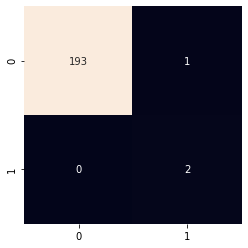

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as plt
mat = confusion_matrix(labels, y_test)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])

In [67]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, labels)

0.9948979591836735

In [68]:
from sklearn.metrics import classification_report

print (classification_report(y_test, labels, target_names=['non-doc', 'doc']))

              precision    recall  f1-score   support

     non-doc       1.00      0.99      1.00       194
         doc       0.67      1.00      0.80         2

    accuracy                           0.99       196
   macro avg       0.83      1.00      0.90       196
weighted avg       1.00      0.99      1.00       196



In [69]:
import joblib
joblib.dump(neo_pipeline, 'mowe_pipeline_model.pkl') 

['mowe_pipeline_model.pkl']